In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import os

# Step 1. CSV 로딩 및 병합
files = {
    'train': [
        '/Users/bangseog-yeong/Downloads/tep/archive/TEP_FaultFree_Training.csv',
        '/Users/bangseog-yeong/Downloads/tep/archive/TEP_Faulty_Training.csv'
    ],
    'test': [
        '/Users/bangseog-yeong/Downloads/tep/archive/TEP_FaultFree_Testing.csv',
        '/Users/bangseog-yeong/Downloads/tep/archive/TEP_Faulty_Testing.csv'
    ]
}

def load_and_concat(file_list):
    return pd.concat([pd.read_csv(f) for f in file_list], axis=0, ignore_index=True)

train = load_and_concat(files['train'])
test = load_and_concat(files['test'])

# Step 2. faultNumber ∈ [0~12]만 사용
valid_faults = list(range(13))  # fault 0~12
train = train[train['faultNumber'].isin(valid_faults)]
test = test[test['faultNumber'].isin(valid_faults)]

# Step 3. 정규화 (fault_0 기준)
sensor_cols = [col for col in train.columns if 'xmeas' in col or 'xmv' in col]
fault0 = train[train['faultNumber'] == 0]
scaler = StandardScaler().fit(fault0[sensor_cols])  # fault_0만 기준

train[sensor_cols] = scaler.transform(train[sensor_cols])
test[sensor_cols] = scaler.transform(test[sensor_cols])

# Step 4. fault별 저장 (지정된 디렉토리 사용)
train_dir = '/Users/bangseog-yeong/Downloads/tep/data/train/train_fault'
test_dir = '/Users/bangseog-yeong/Downloads/tep/data/test/test_fault'

def save_by_fault(df, split, out_dir):
    os.makedirs(out_dir, exist_ok=True)
    for f in valid_faults:
        df_f = df[df['faultNumber'] == f]
        out_path = os.path.join(out_dir, f'{split}_fault_{f}.csv')
        df_f[['sample', 'simulationRun', 'faultNumber'] + sensor_cols].to_csv(out_path, index=False)

save_by_fault(train, 'train', train_dir)
save_by_fault(test, 'test', test_dir)

In [32]:
import pandas as pd

df = pd.read_csv('/Users/bangseog-yeong/Downloads/tep/data/train/train_fault/train_fault_7.csv')
print(df.columns.tolist())

['sample', 'simulationRun', 'faultNumber', 'xmeas_1', 'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6', 'xmeas_7', 'xmeas_8', 'xmeas_9', 'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14', 'xmeas_15', 'xmeas_16', 'xmeas_17', 'xmeas_18', 'xmeas_19', 'xmeas_20', 'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24', 'xmeas_25', 'xmeas_26', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30', 'xmeas_31', 'xmeas_32', 'xmeas_33', 'xmeas_34', 'xmeas_35', 'xmeas_36', 'xmeas_37', 'xmeas_38', 'xmeas_39', 'xmeas_40', 'xmeas_41', 'xmv_1', 'xmv_2', 'xmv_3', 'xmv_4', 'xmv_5', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9', 'xmv_10', 'xmv_11']


In [34]:
print(df['simulationRun'].unique())  # fault_7의 경우 1개만 나올 가능성 높음

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 24

In [39]:
import os
import pandas as pd
import numpy as np

def sliding_window(df, window_size, stride, feature_cols):
    """
    df: DataFrame for one sample × simulationRun group, 시간 순 정렬된 상태여야 함
    window_size: 윈도우 크기 (타임스텝 수)
    stride: 윈도우 이동 간격
    feature_cols: 입력으로 사용할 컬럼 리스트

    반환: X (num_windows, window_size, num_features)
    """
    data = df[feature_cols].values
    n_samples = data.shape[0]

    windows = []
    for start in range(0, n_samples - window_size + 1, stride):
        window = data[start:start+window_size]
        windows.append(window)

    return np.array(windows)


def generate_windows_from_fault_csv(filepath, window_size, stride, feature_cols):
    """
    한 fault CSV에서 슬라이딩 윈도우 생성

    반환:
        X_all: (전체 윈도우 수, window_size, num_features)
        Y_all: (전체 윈도우 수,) 각 윈도우의 faultNumber (여기서는 고장 여부로 라벨링 가능)
    """
    df = pd.read_csv(filepath)

    X_all = []
    Y_all = []

    # sample은 시간 정렬 기준으로만 사용
    grouped = df.groupby('simulationRun')

    for sim_run, group_df in grouped:
        group_df = group_df.sort_values('sample')  # sample 기준 정렬

        # 슬라이딩 윈도우 생성
        windows = sliding_window(group_df, window_size, stride, feature_cols)
        if len(windows) == 0:
            continue

        fault_label = group_df['faultNumber'].iloc[0]
        labels = np.full(len(windows), fault_label)

        X_all.append(windows)
        Y_all.append(labels)

    if len(X_all) == 0:
        return None, None

    X_all = np.vstack(X_all)
    Y_all = np.concatenate(Y_all)
    return X_all, Y_all


# 설정값 예시
window_size = 100
stride = 10

# 사용할 컬럼 예시 (센서 + 조작 변수)
feature_cols = [f'xmeas_{i}' for i in range(1, 42)] + [f'xmv_{i}' for i in range(1, 12)]  

# 저장 경로
train_dir = '/Users/bangseog-yeong/Downloads/tep/data/train/train_fault'
test_dir = '/Users/bangseog-yeong/Downloads/tep/data/test/test_fault'


# train_dir 내 fault별 CSV 파일 리스트 순회
import glob

train_files = glob.glob(os.path.join(train_dir, '*.csv'))

for train_file in train_files:
    fault_num = int(os.path.basename(train_file).split('_')[-1].split('.')[0])
    print(f'Processing fault {fault_num} file: {train_file}')

    X, Y = generate_windows_from_fault_csv(train_file, window_size, stride, feature_cols)

    if X is None:
        print(f'No windows generated for fault {fault_num}')
        continue

    print(f'Generated {X.shape[0]} windows for fault {fault_num}, each shape: {X.shape[1:]}')
    print(f'Label distribution: {np.bincount(Y)}')

    # 이후 X, Y를 npy 저장 또는 모델 입력용으로 변환 가능
    save_dir = '/Users/bangseog-yeong/Downloads/tep/data/train/processed_train_data'
    os.makedirs(save_dir, exist_ok=True)
    np.save(f'{save_dir}/train_fault_{fault_num}_X.npy', X)
    np.save(f'{save_dir}/train_fault_{fault_num}_Y.npy', Y)

Processing fault 7 file: /Users/bangseog-yeong/Downloads/tep/data/train/train_fault/train_fault_7.csv
Generated 20500 windows for fault 7, each shape: (100, 52)
Label distribution: [    0     0     0     0     0     0     0 20500]
Processing fault 6 file: /Users/bangseog-yeong/Downloads/tep/data/train/train_fault/train_fault_6.csv
Generated 20500 windows for fault 6, each shape: (100, 52)
Label distribution: [    0     0     0     0     0     0 20500]
Processing fault 4 file: /Users/bangseog-yeong/Downloads/tep/data/train/train_fault/train_fault_4.csv
Generated 20500 windows for fault 4, each shape: (100, 52)
Label distribution: [    0     0     0     0 20500]
Processing fault 5 file: /Users/bangseog-yeong/Downloads/tep/data/train/train_fault/train_fault_5.csv
Generated 20500 windows for fault 5, each shape: (100, 52)
Label distribution: [    0     0     0     0     0 20500]
Processing fault 1 file: /Users/bangseog-yeong/Downloads/tep/data/train/train_fault/train_fault_1.csv
Generated 

In [40]:
# test_dir 내 fault별 CSV 파일 리스트 순회
import glob

test_files = glob.glob(os.path.join(test_dir, '*.csv'))

for test_file in test_files:
    fault_num = int(os.path.basename(test_file).split('_')[-1].split('.')[0])
    print(f'Processing fault {fault_num} file: {test_file}')

    X, Y = generate_windows_from_fault_csv(test_file, window_size, stride, feature_cols)

    if X is None:
        print(f'No windows generated for fault {fault_num}')
        continue

    print(f'Generated {X.shape[0]} windows for fault {fault_num}, each shape: {X.shape[1:]}')
    print(f'Label distribution: {np.bincount(Y)}')

    # 이후 X, Y를 npy 저장 또는 모델 입력용으로 변환 가능
    save_dir = '/Users/bangseog-yeong/Downloads/tep/data/test/processed_test_data'
    os.makedirs(save_dir, exist_ok=True)
    np.save(f'{save_dir}/test_fault_{fault_num}_X.npy', X)
    np.save(f'{save_dir}/test_fault_{fault_num}_Y.npy', Y)

Processing fault 8 file: /Users/bangseog-yeong/Downloads/tep/data/test/test_fault/test_fault_8.csv
Generated 43500 windows for fault 8, each shape: (100, 52)
Label distribution: [    0     0     0     0     0     0     0     0 43500]
Processing fault 9 file: /Users/bangseog-yeong/Downloads/tep/data/test/test_fault/test_fault_9.csv
Generated 43500 windows for fault 9, each shape: (100, 52)
Label distribution: [    0     0     0     0     0     0     0     0     0 43500]
Processing fault 1 file: /Users/bangseog-yeong/Downloads/tep/data/test/test_fault/test_fault_1.csv
Generated 43500 windows for fault 1, each shape: (100, 52)
Label distribution: [    0 43500]
Processing fault 0 file: /Users/bangseog-yeong/Downloads/tep/data/test/test_fault/test_fault_0.csv
Generated 43500 windows for fault 0, each shape: (100, 52)
Label distribution: [43500]
Processing fault 2 file: /Users/bangseog-yeong/Downloads/tep/data/test/test_fault/test_fault_2.csv
Generated 43500 windows for fault 2, each shape: 

In [42]:
import os
import numpy as np

train_save_dir = '/Users/bangseog-yeong/Downloads/tep/data/train/processed_train_data'
test_save_dir = '/Users/bangseog-yeong/Downloads/tep/data/test/processed_test_data'

def print_label_distribution(Y, max_fault_num=12):
    counts = np.bincount(Y, minlength=max_fault_num + 1)
    nonzero_counts = {int(i): int(count) for i, count in enumerate(counts) if count > 0}  # int 변환
    return nonzero_counts

for fault_num in range(13):  # Fault 0 ~ Fault 12
    # Load Y arrays
    train_y_path = os.path.join(train_save_dir, f'train_fault_{fault_num}_Y.npy')
    test_y_path = os.path.join(test_save_dir, f'test_fault_{fault_num}_Y.npy')
    
    if os.path.exists(train_y_path) and os.path.exists(test_y_path):
        train_Y = np.load(train_y_path)
        test_Y = np.load(test_y_path)
        
        train_dist = print_label_distribution(train_Y)
        test_dist = print_label_distribution(test_Y)

        print(f"Train fault {fault_num}:\nLabel distribution: {train_dist}")
        print(f"Test fault {fault_num}:\nLabel distribution: {test_dist}")

Train fault 0:
Label distribution: {0: 20500}
Test fault 0:
Label distribution: {0: 43500}
Train fault 1:
Label distribution: {1: 20500}
Test fault 1:
Label distribution: {1: 43500}
Train fault 2:
Label distribution: {2: 20500}
Test fault 2:
Label distribution: {2: 43500}
Train fault 3:
Label distribution: {3: 20500}
Test fault 3:
Label distribution: {3: 43500}
Train fault 4:
Label distribution: {4: 20500}
Test fault 4:
Label distribution: {4: 43500}
Train fault 5:
Label distribution: {5: 20500}
Test fault 5:
Label distribution: {5: 43500}
Train fault 6:
Label distribution: {6: 20500}
Test fault 6:
Label distribution: {6: 43500}
Train fault 7:
Label distribution: {7: 20500}
Test fault 7:
Label distribution: {7: 43500}
Train fault 8:
Label distribution: {8: 20500}
Test fault 8:
Label distribution: {8: 43500}
Train fault 9:
Label distribution: {9: 20500}
Test fault 9:
Label distribution: {9: 43500}
Train fault 10:
Label distribution: {10: 20500}
Test fault 10:
Label distribution: {10: 43

In [2]:
import os
import numpy as np
from collections import Counter
from sklearn.utils import resample
import gc

def balance_single_fault(X, Y, n_samples):
    """
    단일 고장 클래스에서 n_samples만큼 무작위 샘플링 (X, Y 동시 리턴)
    """
    assert len(X) == len(Y), "X와 Y 길이가 다릅니다."
    
    X_resampled, Y_resampled = resample(
        X, Y, n_samples=n_samples, replace=False, random_state=0
    )
    return X_resampled, Y_resampled

In [ ]:
# 설정 경로
train_base_dir = '/Users/bangseog-yeong/Downloads/tep/data/train/processed_train_data'
balanced_dir = os.path.join(train_save_dir, '..', 'balanced')
os.makedirs(balanced_dir, exist_ok=True)

# 1. 최소 샘플 수 확인
label_counts = {}

for file in os.listdir(train_save_dir):
    if file.endswith('_Y.npy'):
        fault_num = int(file.split('_')[-2])
        y_path = os.path.join(train_save_dir, file)
        Y = np.load(y_path, mmap_mode='r')  # 메모리 효율적으로
        label_counts[fault_num] = len(Y)

min_samples = min(label_counts.values())
print(f"Minimum samples per class: {min_samples}")

# 2. 클래스별 처리 및 저장
for file in os.listdir(train_save_dir):
    if file.endswith('_X.npy'):
        fault_num = file.split('_')[-2]
        x_path = os.path.join(train_save_dir, file)
        y_path = os.path.join(train_save_dir, f"train_fault_{fault_num}_Y.npy")

        # 파일 존재 여부 확인
        if not os.path.exists(x_path) or not os.path.exists(y_path):
            print(f"파일 누락: fault {fault_num}")
            continue

        X = np.load(x_path)
        Y = np.load(y_path)

        print(f"[{fault_num}] Before: {X.shape[0]}")
        X_bal, Y_bal = balance_single_fault(X, Y, n_samples=min_samples)
        print(f"[{fault_num}] After: {X_bal.shape[0]}")

        # 저장
        np.save(os.path.join(balanced_dir, f'train_fault_{fault_num}_X.npy'), X_bal)
        np.save(os.path.join(balanced_dir, f'train_fault_{fault_num}_Y.npy'), Y_bal)

        # 메모리 정리
        del X, Y, X_bal, Y_bal
        gc.collect()

Minimum samples per class: 20500
[8] Before: 20500
[8] After: 20500
[9] Before: 20500
[9] After: 20500
[7] Before: 20500
[7] After: 20500
[10] Before: 20500
[10] After: 20500
[12] Before: 20500
[12] After: 20500
[5] Before: 20500
[5] After: 20500
[1] Before: 20500
[1] After: 20500
[3] Before: 20500
[3] After: 20500
[4] Before: 20500
[4] After: 20500
[6] Before: 20500
[6] After: 20500
[11] Before: 20500
[11] After: 20500
[2] Before: 20500
[2] After: 20500
[0] Before: 20500
[0] After: 20500


In [4]:
# 설정 경로
test_save_dir = '/Users/bangseog-yeong/Downloads/tep/data/test/processed_test_data'
balanced_dir = os.path.join(test_save_dir, '..', 'balanced')
os.makedirs(balanced_dir, exist_ok=True)

# 1. 최소 샘플 수 확인
label_counts = {}

for file in os.listdir(test_save_dir):
    if file.endswith('_Y.npy'):
        fault_num = int(file.split('_')[-2])
        y_path = os.path.join(test_save_dir, file)
        Y = np.load(y_path, mmap_mode='r')  # 메모리 효율적으로
        label_counts[fault_num] = len(Y)

min_samples = min(label_counts.values())
print(f"Minimum samples per class: {min_samples}")

# 2. 클래스별 처리 및 저장
for file in os.listdir(test_save_dir):
    if file.endswith('_X.npy'):
        fault_num = file.split('_')[-2]
        x_path = os.path.join(test_save_dir, file)
        y_path = os.path.join(test_save_dir, f"test_fault_{fault_num}_Y.npy")

        # 파일 존재 여부 확인
        if not os.path.exists(x_path) or not os.path.exists(y_path):
            print(f"파일 누락: fault {fault_num}")
            continue

        X = np.load(x_path)
        Y = np.load(y_path)

        print(f"[{fault_num}] Before: {X.shape[0]}")
        X_bal, Y_bal = balance_single_fault(X, Y, n_samples=min_samples)
        print(f"[{fault_num}] After: {X_bal.shape[0]}")

        # 저장
        np.save(os.path.join(balanced_dir, f'test_fault_{fault_num}_X.npy'), X_bal)
        np.save(os.path.join(balanced_dir, f'test_fault_{fault_num}_Y.npy'), Y_bal)

        # 메모리 정리
        del X, Y, X_bal, Y_bal
        gc.collect()

Minimum samples per class: 43500
[8] Before: 43500
[8] After: 43500
[9] Before: 43500
[9] After: 43500
[3] Before: 43500
[3] After: 43500
[1] Before: 43500
[1] After: 43500
[12] Before: 43500
[12] After: 43500
[5] Before: 43500
[5] After: 43500
[7] Before: 43500
[7] After: 43500
[10] Before: 43500
[10] After: 43500
[0] Before: 43500
[0] After: 43500
[2] Before: 43500
[2] After: 43500
[6] Before: 43500
[6] After: 43500
[11] Before: 43500
[11] After: 43500
[4] Before: 43500
[4] After: 43500


In [8]:
import numpy as np
from collections import Counter

for i in range(13):
    y_path = f"/Users/bangseog-yeong/Downloads/tep/data/train/balanced/train_fault_{i}_Y.npy"
    Y = np.load(y_path)
    print(f"Train Fault {i}: Label distribution {Counter(Y)}")

Train Fault 0: Label distribution Counter({np.int64(0): 20500})
Train Fault 1: Label distribution Counter({np.int64(1): 20500})
Train Fault 2: Label distribution Counter({np.int64(2): 20500})
Train Fault 3: Label distribution Counter({np.int64(3): 20500})
Train Fault 4: Label distribution Counter({np.int64(4): 20500})
Train Fault 5: Label distribution Counter({np.int64(5): 20500})
Train Fault 6: Label distribution Counter({np.int64(6): 20500})
Train Fault 7: Label distribution Counter({np.int64(7): 20500})
Train Fault 8: Label distribution Counter({np.int64(8): 20500})
Train Fault 9: Label distribution Counter({np.int64(9): 20500})
Train Fault 10: Label distribution Counter({np.int64(10): 20500})
Train Fault 11: Label distribution Counter({np.int64(11): 20500})
Train Fault 12: Label distribution Counter({np.int64(12): 20500})


In [9]:
import numpy as np
import os

def load_and_concat_normal_and_fault(train_dir, fault_num):
    """
    fault_num에 해당하는 고장 데이터와 정상(0) 데이터를 함께 불러와서 병합
    """
    # 정상
    x_path_normal = os.path.join(train_dir, 'train_fault_0_X.npy')
    y_path_normal = os.path.join(train_dir, 'train_fault_0_Y.npy')

    # 해당 고장
    x_path_fault = os.path.join(train_dir, f'train_fault_{fault_num}_X.npy')
    y_path_fault = os.path.join(train_dir, f'train_fault_{fault_num}_Y.npy')

    # 로드
    X_normal = np.load(x_path_normal)
    Y_normal = np.load(y_path_normal)
    X_fault = np.load(x_path_fault)
    Y_fault = np.load(y_path_fault)

    # 병합
    X_concat = np.concatenate([X_normal, X_fault], axis=0)
    Y_concat = np.concatenate([Y_normal, Y_fault], axis=0)

    return X_concat, Y_concat

def convert_to_binary_labels(Y, target_fault):
    """
    fault_num이면 1, 나머지는 0으로 변환
    """
    return np.where(Y == target_fault, 1, 0)

In [10]:
# 디렉터리 경로
train_base_dir = '/Users/bangseog-yeong/Downloads/tep/data/train/balanced'
output_dir = '/Users/bangseog-yeong/Downloads/tep/data/train/binary_train_data'
os.makedirs(output_dir, exist_ok=True)

# fault 1~12 에 대해 반복
for fault_num in range(1, 13):
    X_combined, Y_combined = load_and_concat_normal_and_fault(train_base_dir, fault_num)
    Y_binary = convert_to_binary_labels(Y_combined, fault_num)

    # 저장
    x_save_path = os.path.join(output_dir, f'binary_fault_{fault_num}_X.npy')
    y_save_path = os.path.join(output_dir, f'binary_fault_{fault_num}_Y.npy')
    np.save(x_save_path, X_combined)
    np.save(y_save_path, Y_binary)

    # 분포 확인
    from collections import Counter
    print(f"Fault {fault_num} binary label distribution: {Counter(Y_binary)}")

Fault 1 binary label distribution: Counter({np.int64(0): 20500, np.int64(1): 20500})
Fault 2 binary label distribution: Counter({np.int64(0): 20500, np.int64(1): 20500})
Fault 3 binary label distribution: Counter({np.int64(0): 20500, np.int64(1): 20500})
Fault 4 binary label distribution: Counter({np.int64(0): 20500, np.int64(1): 20500})
Fault 5 binary label distribution: Counter({np.int64(0): 20500, np.int64(1): 20500})
Fault 6 binary label distribution: Counter({np.int64(0): 20500, np.int64(1): 20500})
Fault 7 binary label distribution: Counter({np.int64(0): 20500, np.int64(1): 20500})
Fault 8 binary label distribution: Counter({np.int64(0): 20500, np.int64(1): 20500})
Fault 9 binary label distribution: Counter({np.int64(0): 20500, np.int64(1): 20500})
Fault 10 binary label distribution: Counter({np.int64(0): 20500, np.int64(1): 20500})
Fault 11 binary label distribution: Counter({np.int64(0): 20500, np.int64(1): 20500})
Fault 12 binary label distribution: Counter({np.int64(0): 20500

In [23]:
import numpy as np
import os

# 정상 (fault 0) 데이터만 불러와서 라벨 0 부여
fault0_x_path = os.path.join(train_base_dir, 'train_fault_0_X.npy')
fault0_y_path = os.path.join(train_base_dir, 'train_fault_0_Y.npy')

X_fault0 = np.load(fault0_x_path)
Y_binary_fault0 = np.zeros(X_fault0.shape[0], dtype=int)  # 전부 0 (정상)

# 저장
op_dir = '/Users/bangseog-yeong/Downloads/tep/data/train/binary_train_data'
x_save_path_0 = os.path.join(op_dir, 'binary_fault_0_X.npy')
y_save_path_0 = os.path.join(op_dir, 'binary_fault_0_Y.npy')
np.save(x_save_path_0, X_fault0)
np.save(y_save_path_0, Y_binary_fault0)

from collections import Counter
print(f"Fault 0 binary label distribution: {Counter(Y_binary_fault0)}")

Fault 0 binary label distribution: Counter({np.int64(0): 20500})


In [12]:
import numpy as np
import os

def load_and_concat_normal_and_fault(test_dir, fault_num):
    """
    fault_num에 해당하는 고장 데이터와 정상(0) 데이터를 함께 불러와서 병합
    """
    # 정상
    x_path_normal = os.path.join(test_dir, 'test_fault_0_X.npy')
    y_path_normal = os.path.join(test_dir, 'test_fault_0_Y.npy')

    # 해당 고장
    x_path_fault = os.path.join(test_dir, f'test_fault_{fault_num}_X.npy')
    y_path_fault = os.path.join(test_dir, f'test_fault_{fault_num}_Y.npy')

    # 로드
    X_normal = np.load(x_path_normal)
    Y_normal = np.load(y_path_normal)
    X_fault = np.load(x_path_fault)
    Y_fault = np.load(y_path_fault)

    # 병합
    X_concat = np.concatenate([X_normal, X_fault], axis=0)
    Y_concat = np.concatenate([Y_normal, Y_fault], axis=0)

    return X_concat, Y_concat

def convert_to_binary_labels(Y, target_fault):
    """
    fault_num이면 1, 나머지는 0으로 변환
    """
    return np.where(Y == target_fault, 1, 0)

In [ ]:
# 디렉터리 경로
test_base_dir = '/Users/bangseog-yeong/Downloads/tep/data/test/balanced'
output_dir = '/Users/bangseog-yeong/Downloads/tep/data/test/binary_test_data'
os.makedirs(output_dir, exist_ok=True)

# fault 1~12 에 대해 반복
for fault_num in range(1, 13):
    X_combined, Y_combined = load_and_concat_normal_and_fault(test_base_dir, fault_num)
    Y_binary = convert_to_binary_labels(Y_combined, fault_num)

    # 저장
    x_save_path = os.path.join(output_dir, f'binary_fault_{fault_num}_X.npy')
    y_save_path = os.path.join(output_dir, f'binary_fault_{fault_num}_Y.npy')
    np.save(x_save_path, X_combined)
    np.save(y_save_path, Y_binary)

    # 분포 확인
    from collections import Counter
    print(f"Fault {fault_num} binary label distribution: {Counter(Y_binary)}")

Fault 1 binary label distribution: Counter({np.int64(0): 43500, np.int64(1): 43500})
Fault 2 binary label distribution: Counter({np.int64(0): 43500, np.int64(1): 43500})
Fault 3 binary label distribution: Counter({np.int64(0): 43500, np.int64(1): 43500})
Fault 4 binary label distribution: Counter({np.int64(0): 43500, np.int64(1): 43500})
Fault 5 binary label distribution: Counter({np.int64(0): 43500, np.int64(1): 43500})
Fault 6 binary label distribution: Counter({np.int64(0): 43500, np.int64(1): 43500})
Fault 7 binary label distribution: Counter({np.int64(0): 43500, np.int64(1): 43500})
Fault 8 binary label distribution: Counter({np.int64(0): 43500, np.int64(1): 43500})
Fault 9 binary label distribution: Counter({np.int64(0): 43500, np.int64(1): 43500})
Fault 10 binary label distribution: Counter({np.int64(0): 43500, np.int64(1): 43500})
Fault 11 binary label distribution: Counter({np.int64(0): 43500, np.int64(1): 43500})
Fault 12 binary label distribution: Counter({np.int64(0): 43500

In [24]:
import numpy as np
import os

# 정상 (fault 0) 데이터만 불러와서 라벨 0 부여
fault0_x_path = os.path.join(test_base_dir, 'test_fault_0_X.npy')
fault0_y_path = os.path.join(test_base_dir, 'test_fault_0_Y.npy')

X_fault0 = np.load(fault0_x_path)
Y_binary_fault0 = np.zeros(X_fault0.shape[0], dtype=int)  # 전부 0 (정상)

# 저장
x_save_path_0 = os.path.join(output_dir, 'binary_fault_0_X.npy')
y_save_path_0 = os.path.join(output_dir, 'binary_fault_0_Y.npy')
np.save(x_save_path_0, X_fault0)
np.save(y_save_path_0, Y_binary_fault0)

from collections import Counter
print(f"Fault 0 binary label distribution: {Counter(Y_binary_fault0)}")

Fault 0 binary label distribution: Counter({np.int64(0): 43500})


In [20]:
import os
import numpy as np

def load_and_inspect_binary_files(base_dir):
    """
    base_dir 경로에서 binary_fault_{fault_num}_X.npy, Y.npy 파일을 모두 찾아 로드 후 구조 출력
    """
    files = os.listdir(base_dir)
    
    # fault_num 추출 및 X, Y 쌍으로 그룹핑
    fault_nums = set()
    for f in files:
        if f.startswith('binary_fault_') and (f.endswith('_X.npy') or f.endswith('_Y.npy')):
            # 파일명 예: binary_fault_1_X.npy
            parts = f.split('_')
            if len(parts) >= 4:
                fault_nums.add(parts[2])
    fault_nums = sorted(fault_nums, key=lambda x: int(x))  # 숫자 순 정렬
    
    for fault_num in fault_nums:
        x_path = os.path.join(base_dir, f'binary_fault_{fault_num}_X.npy')
        y_path = os.path.join(base_dir, f'binary_fault_{fault_num}_Y.npy')

        if os.path.exists(x_path) and os.path.exists(y_path):
            X = np.load(x_path)
            Y = np.load(y_path)
            print(f'Fault {fault_num} - X shape: {X.shape}, dtype: {X.dtype}')
            print(f'Fault {fault_num} - Y shape: {Y.shape}, dtype: {Y.dtype}')
            print(f'Fault {fault_num} - Y label distribution: {np.unique(Y, return_counts=True)}')
        else:
            print(f'Fault {fault_num} 파일 쌍이 존재하지 않음')

# 경로 설정
train_dir = '/Users/bangseog-yeong/Downloads/tep/data/train/binary_train_data'
test_dir = '/Users/bangseog-yeong/Downloads/tep/data/test/binary_test_data'

print("=== Train 데이터 구조 확인 ===")
load_and_inspect_binary_files(train_dir)

print("\n=== Test 데이터 구조 확인 ===")
load_and_inspect_binary_files(test_dir)

=== Train 데이터 구조 확인 ===
Fault 1 - X shape: (41000, 100, 52), dtype: float64
Fault 1 - Y shape: (41000,), dtype: int64
Fault 1 - Y label distribution: (array([0, 1]), array([20500, 20500]))
Fault 2 - X shape: (41000, 100, 52), dtype: float64
Fault 2 - Y shape: (41000,), dtype: int64
Fault 2 - Y label distribution: (array([0, 1]), array([20500, 20500]))
Fault 3 - X shape: (41000, 100, 52), dtype: float64
Fault 3 - Y shape: (41000,), dtype: int64
Fault 3 - Y label distribution: (array([0, 1]), array([20500, 20500]))
Fault 4 - X shape: (41000, 100, 52), dtype: float64
Fault 4 - Y shape: (41000,), dtype: int64
Fault 4 - Y label distribution: (array([0, 1]), array([20500, 20500]))
Fault 5 - X shape: (41000, 100, 52), dtype: float64
Fault 5 - Y shape: (41000,), dtype: int64
Fault 5 - Y label distribution: (array([0, 1]), array([20500, 20500]))
Fault 6 - X shape: (41000, 100, 52), dtype: float64
Fault 6 - Y shape: (41000,), dtype: int64
Fault 6 - Y label distribution: (array([0, 1]), array([20

In [25]:
# fault 0의 binary 데이터를 따로 불러와 구조 확인
for dataset_name, base_dir in [("Train", train_dir), ("Test", test_dir)]:
    x_path = os.path.join(base_dir, 'binary_fault_0_X.npy')
    y_path = os.path.join(base_dir, 'binary_fault_0_Y.npy')

    if os.path.exists(x_path) and os.path.exists(y_path):
        X = np.load(x_path)
        Y = np.load(y_path)
        print(f'=== {dataset_name} Fault 0 구조 확인 ===')
        print(f'X shape: {X.shape}, dtype: {X.dtype}')
        print(f'Y shape: {Y.shape}, dtype: {Y.dtype}')
        print(f'Y label distribution: {np.unique(Y, return_counts=True)}\n')
    else:
        print(f'{dataset_name} 데이터셋에 fault 0 파일이 존재하지 않습니다.\n')

=== Train Fault 0 구조 확인 ===
X shape: (20500, 100, 52), dtype: float64
Y shape: (20500,), dtype: int64
Y label distribution: (array([0]), array([20500]))

=== Test Fault 0 구조 확인 ===
X shape: (43500, 100, 52), dtype: float64
Y shape: (43500,), dtype: int64
Y label distribution: (array([0]), array([43500]))



In [27]:
import numpy as np

def create_onset_based_labels(Y_raw, onset_index=160):
    """
    시계열 Y_raw 라벨(정수 클래스)에서 이상 감지용 binary 라벨 생성
    onset_index 이후는 1, 그 이전은 0

    Args:
        Y_raw: (N,) ndarray, 원본 라벨. 정상(0) 또는 fault 번호 (1~12)
        onset_index: 이상 주입 시점 (default: 160)

    Returns:
        Y_binary: (N,) ndarray, 시계열 기반 binary 라벨 (0 또는 1)
    """
    Y_binary = np.zeros_like(Y_raw, dtype=np.int32)

    # fault 클래스가 존재하는 경우에만 적용
    if np.any(Y_raw != 0):
        # fault가 시작되는 첫 인덱스를 onset_index로 가정
        Y_binary[onset_index:] = 1

    return Y_binary

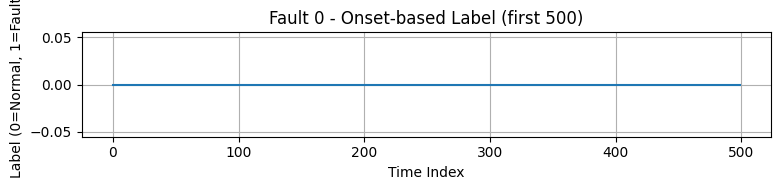

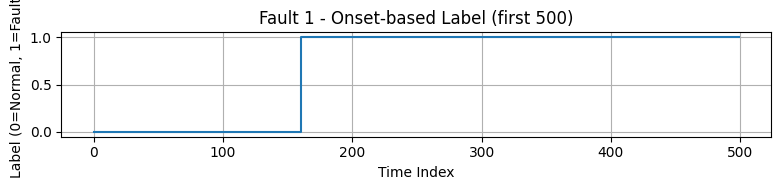

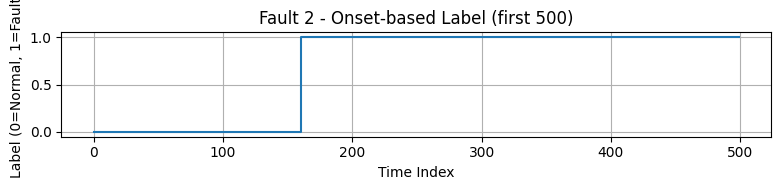

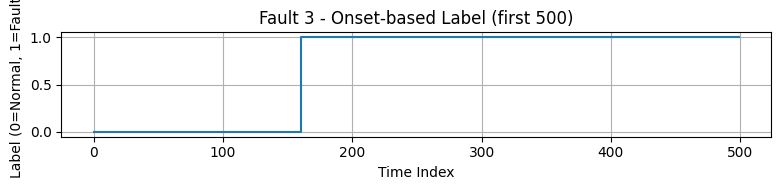

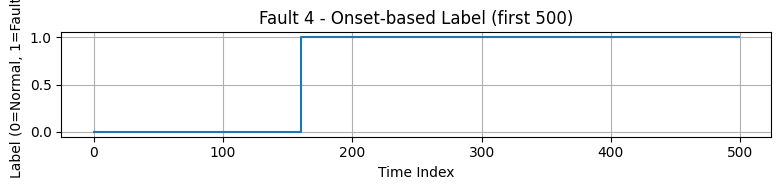

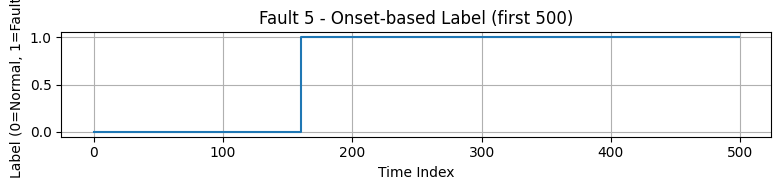

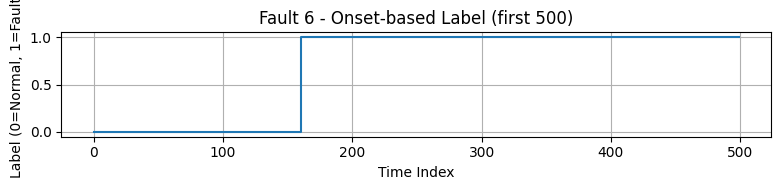

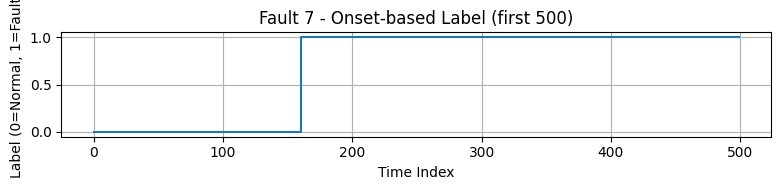

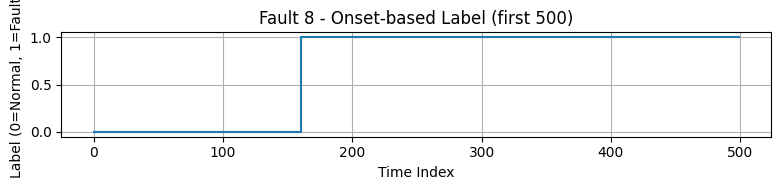

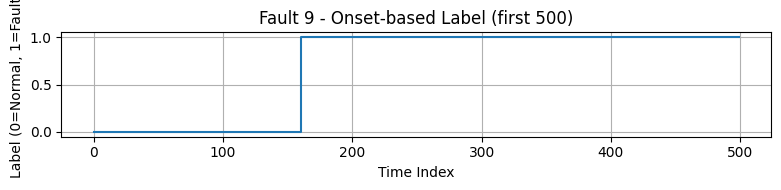

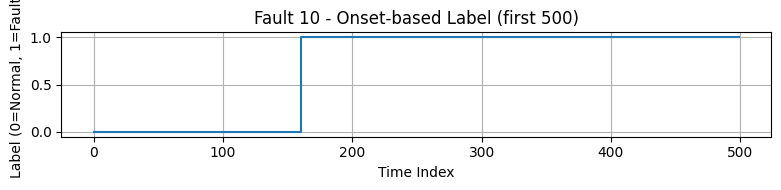

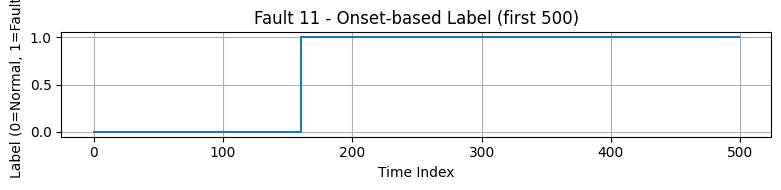

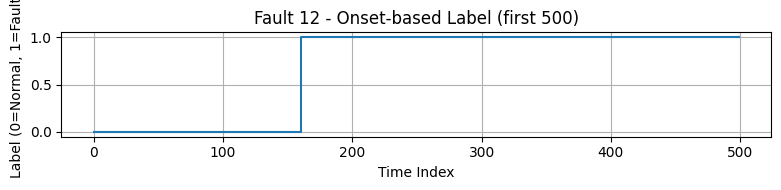

In [30]:
import matplotlib.pyplot as plt

# 경로 설정
base_dir = '/Users/bangseog-yeong/Downloads/tep/data/train/balanced'

# fault 0 ~ 12 반복
for fault_num in range(13):
    y_path = os.path.join(base_dir, f'train_fault_{fault_num}_Y.npy')
    Y_raw = np.load(y_path)

    # onset 기반 이진 라벨 생성
    Y_onset = create_onset_based_labels(Y_raw, onset_index=160)

    # 시각화
    plt.figure(figsize=(8, 2))
    plt.plot(Y_onset[:500], drawstyle='steps-post')
    plt.title(f"Fault {fault_num} - Onset-based Label (first 500)")
    plt.xlabel("Time Index")
    plt.ylabel("Label (0=Normal, 1=Fault)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

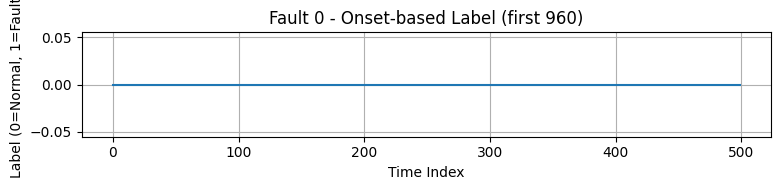

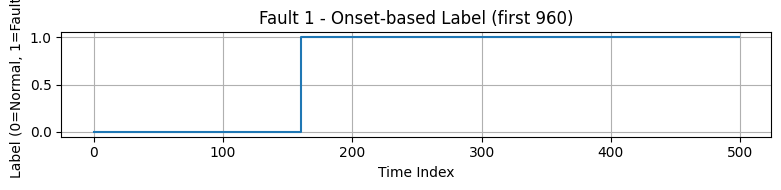

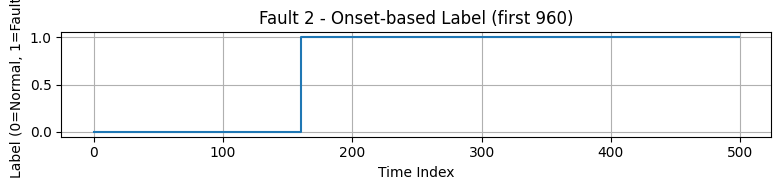

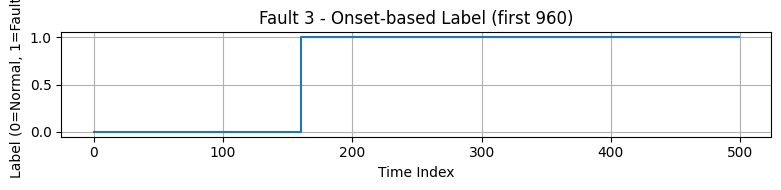

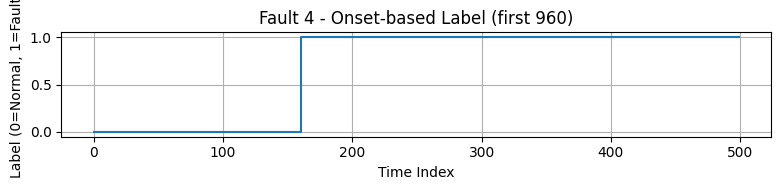

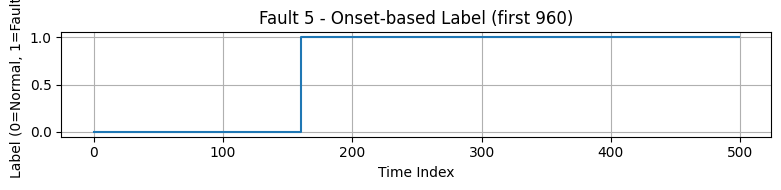

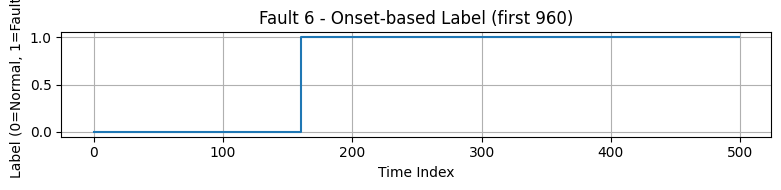

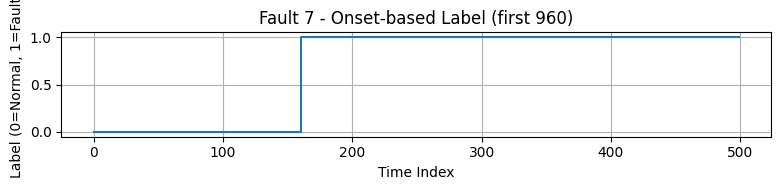

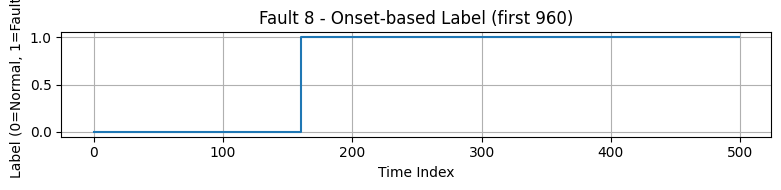

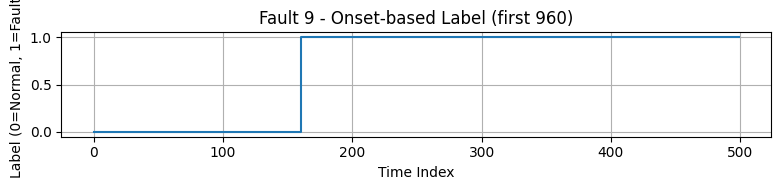

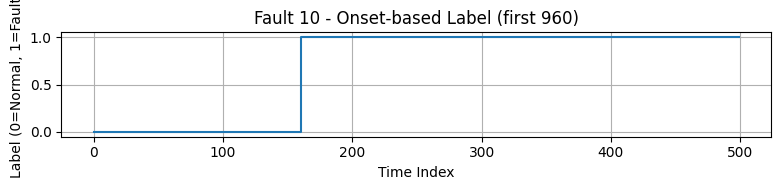

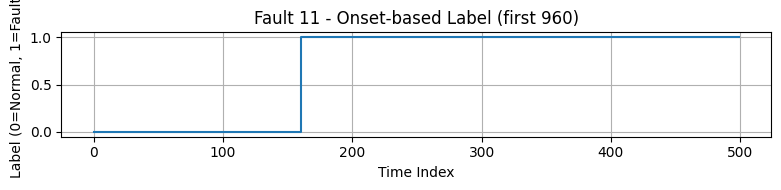

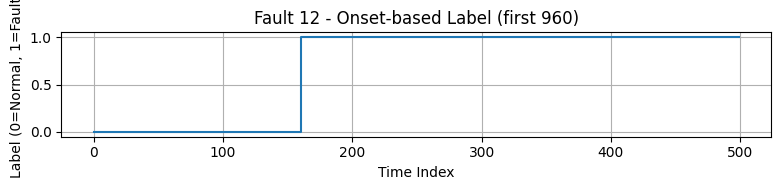

In [31]:
import matplotlib.pyplot as plt

# 경로 설정
base_dir = '/Users/bangseog-yeong/Downloads/tep/data/test/balanced'

# fault 0 ~ 12 반복
for fault_num in range(13):
    y_path = os.path.join(base_dir, f'test_fault_{fault_num}_Y.npy')
    Y_raw = np.load(y_path)

    # onset 기반 이진 라벨 생성
    Y_onset = create_onset_based_labels(Y_raw, onset_index=160)

    # 시각화
    plt.figure(figsize=(8, 2))
    plt.plot(Y_onset[:500], drawstyle='steps-post')
    plt.title(f"Fault {fault_num} - Onset-based Label (first 960)")
    plt.xlabel("Time Index")
    plt.ylabel("Label (0=Normal, 1=Fault)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [51]:
import os
import numpy as np

def create_multiclass_dataset_memmap(base_dir, output_dir, prefix='train'):
    """
    np.memmap을 사용하여 fault별 이진 분류 데이터를 병합하여 멀티클래스 학습 데이터를 생성.
    메모리 효율적 방식.
    """
    os.makedirs(output_dir, exist_ok=True)

    # 1. 전체 샘플 수 및 feature shape 계산
    total_samples = 0
    feature_shape = None
    fault_sample_counts = []

    for fault_num in range(13):
        x_path = os.path.join(base_dir, f'binary_fault_{fault_num}_X.npy')
        if not os.path.exists(x_path):
            print(f"누락: fault_{fault_num}_X.npy")
            continue

        X = np.load(x_path, mmap_mode='r')
        num_samples = X.shape[0]
        fault_sample_counts.append((fault_num, num_samples))
        total_samples += num_samples

        if feature_shape is None:
            feature_shape = X.shape[1:]

    if total_samples == 0 or feature_shape is None:
        raise RuntimeError("병합할 유효한 데이터가 없습니다.")

    print(f"총 샘플 수: {total_samples} | 입력 shape: {feature_shape}")

    # 2. memmap 파일 생성
    x_save_path = os.path.join(output_dir, f'{prefix}_X_multiclass.npy')
    y_save_path = os.path.join(output_dir, f'{prefix}_Y_multiclass.npy')

    X_memmap = np.memmap(x_save_path, dtype='float64', mode='w+', shape=(total_samples, *feature_shape))
    Y_memmap = np.memmap(y_save_path, dtype='int32', mode='w+', shape=(total_samples,))

    # 3. fault별로 데이터를 순차적으로 적재 및 쓰기
    current_idx = 0
    for fault_num, count in fault_sample_counts:
        x_path = os.path.join(base_dir, f'binary_fault_{fault_num}_X.npy')
        X_chunk = np.load(x_path, mmap_mode='r')
        Y_chunk = np.full((count,), fault_num, dtype='int32')

        X_memmap[current_idx:current_idx+count] = X_chunk
        Y_memmap[current_idx:current_idx+count] = Y_chunk

        print(f"Fault {fault_num}: {count}개 → {current_idx}:{current_idx+count}")
        current_idx += count

    # 4. flush
    X_memmap.flush()
    Y_memmap.flush()

    print(f"\n 저장 완료:")
    print(f"  X: {x_save_path} | shape: {X_memmap.shape}")
    print(f"  Y: {y_save_path} | shape: {Y_memmap.shape} | label dist: {np.unique(Y_memmap, return_counts=True)}")

In [53]:
# 경로 설정
train_input_dir = '/Users/bangseog-yeong/Downloads/tep/data/train/binary_train_data'
train_output_dir = '/Users/bangseog-yeong/Downloads/tep/data/train/multiclass_data'

# 멀티클래스 데이터 생성
create_multiclass_dataset_memmap(train_input_dir, train_output_dir, prefix='train')

총 샘플 수: 512500 | 입력 shape: (100, 52)
Fault 0: 20500개 → 0:20500
Fault 1: 41000개 → 20500:61500
Fault 2: 41000개 → 61500:102500
Fault 3: 41000개 → 102500:143500
Fault 4: 41000개 → 143500:184500
Fault 5: 41000개 → 184500:225500
Fault 6: 41000개 → 225500:266500
Fault 7: 41000개 → 266500:307500
Fault 8: 41000개 → 307500:348500
Fault 9: 41000개 → 348500:389500
Fault 10: 41000개 → 389500:430500
Fault 11: 41000개 → 430500:471500
Fault 12: 41000개 → 471500:512500

 저장 완료:
  X: /Users/bangseog-yeong/Downloads/tep/data/train/multiclass_data/train_X_multiclass.npy | shape: (512500, 100, 52)
  Y: /Users/bangseog-yeong/Downloads/tep/data/train/multiclass_data/train_Y_multiclass.npy | shape: (512500,) | label dist: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int32), array([20500, 41000, 41000, 41000, 41000, 41000, 41000, 41000, 41000,
       41000, 41000, 41000, 41000]))


In [11]:
import os
import numpy as np

def create_multiclass_dataset_memmap(base_dir, output_dir, prefix='train'):
    """
    np.memmap을 사용하여 fault별 이진 분류 데이터를 병합하여 멀티클래스 학습 데이터를 생성.
    메모리 효율적 방식.
    """
    os.makedirs(output_dir, exist_ok=True)

    # 1. 전체 샘플 수 및 feature shape 계산
    total_samples = 0
    feature_shape = None
    fault_sample_counts = []

    for fault_num in range(13):
        x_path = os.path.join(base_dir, f'binary_fault_{fault_num}_X.npy')
        if not os.path.exists(x_path):
            print(f"누락: fault_{fault_num}_X.npy")
            continue

        X = np.load(x_path, mmap_mode='r')
        num_samples = X.shape[0]
        fault_sample_counts.append((fault_num, num_samples))
        total_samples += num_samples

        if feature_shape is None:
            feature_shape = X.shape[1:]

    if total_samples == 0 or feature_shape is None:
        raise RuntimeError("병합할 유효한 데이터가 없습니다.")

    print(f"총 샘플 수: {total_samples} | 입력 shape: {feature_shape}")

    # 2. memmap 파일 생성
    x_save_path = os.path.join(output_dir, f'{prefix}_X_multiclass_memmap.npy')
    y_save_path = os.path.join(output_dir, f'{prefix}_Y_multiclass_memmap.npy')

    X_memmap = np.memmap(x_save_path, dtype='float64', mode='w+', shape=(total_samples, *feature_shape))
    Y_memmap = np.memmap(y_save_path, dtype='int32', mode='w+', shape=(total_samples,))

    # 3. fault별로 데이터를 순차적으로 적재 및 쓰기
    current_idx = 0
    for fault_num, count in fault_sample_counts:
        x_path = os.path.join(base_dir, f'binary_fault_{fault_num}_X.npy')
        X_chunk = np.load(x_path, mmap_mode='r')
        Y_chunk = np.full((count,), fault_num, dtype='int32')

        X_memmap[current_idx:current_idx+count] = X_chunk
        Y_memmap[current_idx:current_idx+count] = Y_chunk

        print(f"Fault {fault_num}: {count}개 → {current_idx}:{current_idx+count}")
        current_idx += count

    # 4. flush
    X_memmap.flush()
    Y_memmap.flush()

    print(f"\n 저장 완료:")
    print(f"  X: {x_save_path} | shape: {X_memmap.shape}")
    print(f"  Y: {y_save_path} | shape: {Y_memmap.shape} | label dist: {np.unique(Y_memmap, return_counts=True)}")

In [12]:
test_base = '/Users/bangseog-yeong/Downloads/tep/data/test/binary_test_data'
test_output = '/Users/bangseog-yeong/Downloads/tep/data/test/multiclass_data'

create_multiclass_dataset_memmap(test_base, test_output, prefix='test')

총 샘플 수: 1087500 | 입력 shape: (100, 52)
Fault 0: 43500개 → 0:43500
Fault 1: 87000개 → 43500:130500
Fault 2: 87000개 → 130500:217500
Fault 3: 87000개 → 217500:304500
Fault 4: 87000개 → 304500:391500
Fault 5: 87000개 → 391500:478500
Fault 6: 87000개 → 478500:565500
Fault 7: 87000개 → 565500:652500
Fault 8: 87000개 → 652500:739500
Fault 9: 87000개 → 739500:826500
Fault 10: 87000개 → 826500:913500
Fault 11: 87000개 → 913500:1000500
Fault 12: 87000개 → 1000500:1087500

 저장 완료:
  X: /Users/bangseog-yeong/Downloads/tep/data/test/multiclass_data/test_X_multiclass_memmap.npy | shape: (1087500, 100, 52)
  Y: /Users/bangseog-yeong/Downloads/tep/data/test/multiclass_data/test_Y_multiclass_memmap.npy | shape: (1087500,) | label dist: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int32), array([43500, 87000, 87000, 87000, 87000, 87000, 87000, 87000, 87000,
       87000, 87000, 87000, 87000]))


In [11]:
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 MB 37.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [torch]32m5/6 [torch]]x]


In [27]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os

class BinaryFaultDataset(Dataset):
    def __init__(self, data_dir, fault_num):
        """
        data_dir: 이진 라벨 데이터가 저장된 폴더 경로
        fault_num: 불러올 고장 번호 (0~12)
        """
        x_path = os.path.join(data_dir, f'binary_fault_{fault_num}_X.npy')
        y_path = os.path.join(data_dir, f'binary_fault_{fault_num}_Y.npy')

        self.X = np.load(x_path)  # (N, window_size, features)
        self.Y = np.load(y_path)  # (N,)

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        x = self.X[idx]  # shape: (window_size, features)
        y = self.Y[idx]  # 0 or 1 (binary label)

        # numpy -> tensor, float32 for inputs, long for labels
        x_tensor = torch.tensor(x, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.long)

        return x_tensor, y_tensor


# 사용 예시
data_dir = '/Users/bangseog-yeong/Downloads/tep/data/train/binary_train_data'
fault_num = 11  # 원하는 fault 번호

dataset = BinaryFaultDataset(data_dir, fault_num)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# 데이터 확인
for batch_x, batch_y in dataloader:
    print(batch_x.shape)  # e.g. torch.Size([128, 100, 52])
    print(batch_y[:10])   # e.g. tensor([0, 1, 0, 0, 1, ...])
    break

torch.Size([128, 100, 52])
tensor([0, 0, 0, 1, 1, 0, 0, 1, 1, 1])


In [29]:
data_dir = '/Users/bangseog-yeong/Downloads/tep/data/train/binary_train_data'

x_path = os.path.join(data_dir, f'binary_fault_11_X.npy')
y_path = os.path.join(data_dir, f'binary_fault_11_Y.npy')

X = np.load(x_path)  # (N, window_size, features)
Y = np.load(y_path)  # (N,)

print(X.shape, Y.shape)

(41000, 100, 52) (41000,)


In [13]:
import numpy as np
import os

def convert_large_memmap_to_npy(memmap_path, dtype, shape, output_path=None, batch_size=10000):
    """
    대용량 memmap 데이터를 메모리 적재 없이 일반 .npy 파일로 안전하게 변환.
    """
    if output_path is None:
        base, ext = os.path.splitext(memmap_path)
        output_path = '/Users/bangseog-yeong/Downloads/tep/data/test/multiclass_data/test_X_multiclass.npy'

    # 결과 배열 생성
    out_file = open(output_path, 'wb')
    np.lib.format.write_array_header_1_0(out_file, {
        'descr': np.dtype(dtype).descr,
        'fortran_order': False,
        'shape': shape
    })

    # memmap으로 원본 열기
    mmap_data = np.memmap(memmap_path, dtype=dtype, mode='r', shape=shape)

    # 배치 단위로 저장
    for i in range(0, shape[0], batch_size):
        batch_end = min(i + batch_size, shape[0])
        batch = mmap_data[i:batch_end]
        out_file.write(batch.tobytes())
        print(f"▶ 저장 중: {i} ~ {batch_end} / {shape[0]}")

    out_file.close()
    print(f"변환 완료: {output_path}")

convert_large_memmap_to_npy(
    memmap_path='/Users/bangseog-yeong/Downloads/tep/data/test/multiclass_data/test_X_multiclass_memmap.npy',
    dtype='float64',
    shape=(1087500, 100, 52),
    batch_size=5000
)

▶ 저장 중: 0 ~ 5000 / 1087500
▶ 저장 중: 5000 ~ 10000 / 1087500
▶ 저장 중: 10000 ~ 15000 / 1087500
▶ 저장 중: 15000 ~ 20000 / 1087500
▶ 저장 중: 20000 ~ 25000 / 1087500
▶ 저장 중: 25000 ~ 30000 / 1087500
▶ 저장 중: 30000 ~ 35000 / 1087500
▶ 저장 중: 35000 ~ 40000 / 1087500
▶ 저장 중: 40000 ~ 45000 / 1087500
▶ 저장 중: 45000 ~ 50000 / 1087500
▶ 저장 중: 50000 ~ 55000 / 1087500
▶ 저장 중: 55000 ~ 60000 / 1087500
▶ 저장 중: 60000 ~ 65000 / 1087500
▶ 저장 중: 65000 ~ 70000 / 1087500
▶ 저장 중: 70000 ~ 75000 / 1087500
▶ 저장 중: 75000 ~ 80000 / 1087500
▶ 저장 중: 80000 ~ 85000 / 1087500
▶ 저장 중: 85000 ~ 90000 / 1087500
▶ 저장 중: 90000 ~ 95000 / 1087500
▶ 저장 중: 95000 ~ 100000 / 1087500
▶ 저장 중: 100000 ~ 105000 / 1087500
▶ 저장 중: 105000 ~ 110000 / 1087500
▶ 저장 중: 110000 ~ 115000 / 1087500
▶ 저장 중: 115000 ~ 120000 / 1087500
▶ 저장 중: 120000 ~ 125000 / 1087500
▶ 저장 중: 125000 ~ 130000 / 1087500
▶ 저장 중: 130000 ~ 135000 / 1087500
▶ 저장 중: 135000 ~ 140000 / 1087500
▶ 저장 중: 140000 ~ 145000 / 1087500
▶ 저장 중: 145000 ~ 150000 / 1087500
▶ 저장 중: 150000 ~ 155000 /

In [14]:
import numpy as np
import os

def convert_large_memmap_to_npy(memmap_path, dtype, shape, output_path=None, batch_size=10000):
    """
    대용량 memmap 데이터를 메모리 적재 없이 일반 .npy 파일로 안전하게 변환.
    """
    if output_path is None:
        base, ext = os.path.splitext(memmap_path)
        output_path = '/Users/bangseog-yeong/Downloads/tep/data/test/multiclass_data/test_Y_multiclass.npy'

    # 결과 배열 생성
    out_file = open(output_path, 'wb')
    np.lib.format.write_array_header_1_0(out_file, {
        'descr': np.dtype(dtype).descr,
        'fortran_order': False,
        'shape': shape
    })

    # memmap으로 원본 열기
    mmap_data = np.memmap(memmap_path, dtype=dtype, mode='r', shape=shape)

    # 배치 단위로 저장
    for i in range(0, shape[0], batch_size):
        batch_end = min(i + batch_size, shape[0])
        batch = mmap_data[i:batch_end]
        out_file.write(batch.tobytes())
        print(f"▶ 저장 중: {i} ~ {batch_end} / {shape[0]}")

    out_file.close()
    print(f"변환 완료: {output_path}")

convert_large_memmap_to_npy(
    memmap_path='/Users/bangseog-yeong/Downloads/tep/data/test/multiclass_data/test_Y_multiclass_memmap.npy',
    dtype='int32',
    shape=(1087500,),
    batch_size=20000
)

▶ 저장 중: 0 ~ 20000 / 1087500
▶ 저장 중: 20000 ~ 40000 / 1087500
▶ 저장 중: 40000 ~ 60000 / 1087500
▶ 저장 중: 60000 ~ 80000 / 1087500
▶ 저장 중: 80000 ~ 100000 / 1087500
▶ 저장 중: 100000 ~ 120000 / 1087500
▶ 저장 중: 120000 ~ 140000 / 1087500
▶ 저장 중: 140000 ~ 160000 / 1087500
▶ 저장 중: 160000 ~ 180000 / 1087500
▶ 저장 중: 180000 ~ 200000 / 1087500
▶ 저장 중: 200000 ~ 220000 / 1087500
▶ 저장 중: 220000 ~ 240000 / 1087500
▶ 저장 중: 240000 ~ 260000 / 1087500
▶ 저장 중: 260000 ~ 280000 / 1087500
▶ 저장 중: 280000 ~ 300000 / 1087500
▶ 저장 중: 300000 ~ 320000 / 1087500
▶ 저장 중: 320000 ~ 340000 / 1087500
▶ 저장 중: 340000 ~ 360000 / 1087500
▶ 저장 중: 360000 ~ 380000 / 1087500
▶ 저장 중: 380000 ~ 400000 / 1087500
▶ 저장 중: 400000 ~ 420000 / 1087500
▶ 저장 중: 420000 ~ 440000 / 1087500
▶ 저장 중: 440000 ~ 460000 / 1087500
▶ 저장 중: 460000 ~ 480000 / 1087500
▶ 저장 중: 480000 ~ 500000 / 1087500
▶ 저장 중: 500000 ~ 520000 / 1087500
▶ 저장 중: 520000 ~ 540000 / 1087500
▶ 저장 중: 540000 ~ 560000 / 1087500
▶ 저장 중: 560000 ~ 580000 / 1087500
▶ 저장 중: 580000 ~ 600000 / 1

In [15]:
import numpy as np

X = np.load('/Users/bangseog-yeong/Downloads/tep/data/test/multiclass_data/test_X_multiclass.npy')
Y = np.load('/Users/bangseog-yeong/Downloads/tep/data/test/multiclass_data/test_Y_multiclass.npy')

print(X.shape, Y.shape)

(1087500, 100, 52) (1087500,)


In [ ]:
import numpy as np
import os

def convert_memmap_to_npy(memmap_path, dtype, shape, output_path=None):
    """
    .memmap 형식으로 저장된 데이터를 일반 .npy 파일로 변환합니다.

    Parameters:
        memmap_path (str): memmap 형식의 입력 파일 경로 (.npy 확장자일 수 있음)
        dtype (str or np.dtype): 데이터 타입 (예: 'float64', 'int32' 등)
        shape (tuple): 데이터 shape (예: (512500, 100, 52))
        output_path (str): 저장할 .npy 경로 (생략 시 원래 경로에 '_converted.npy' 추가)
    """
    if output_path is None:
        base, ext = os.path.splitext(memmap_path)
        output_path = base + '.npy'

    # memmap 파일 로딩
    mmap_data = np.memmap(memmap_path, dtype=dtype, mode='r', shape=shape)

    # 일반 numpy array로 메모리에 복사 후 저장
    np.save(output_path, np.array(mmap_data))

    print(f"변환 완료: {output_path}")

# 예시 사용
convert_memmap_to_npy(
    memmap_path='/Users/bangseog-yeong/Downloads/tep/data/test/multiclass_data/test_X_multiclass.npy',
    dtype='float64',
    shape=(512500, 100, 52)
)

convert_memmap_to_npy(
    memmap_path='/Users/bangseog-yeong/Downloads/tep/data/test/multiclass_data/test_Y_multiclass.npy',
    dtype='int32',
    shape=(512500,)
)

In [1]:
import numpy as np

X = np.load('/Users/bangseog-yeong/Downloads/tep/data/train/multiclass_data/train_X_multiclass.npy')
Y = np.load('/Users/bangseog-yeong/Downloads/tep/data/train/multiclass_data/train_Y_multiclass.npy')

print(X.shape, Y.shape)

(512500, 100, 52) (512500,)


In [2]:
import torch
from torch.utils.data import Dataset
import numpy as np
import os

class MulticlassFaultDataset(Dataset):
    def __init__(self, data_dir):
        """
        Args:
            data_dir (str): 'train_X_multiclass.npy' 및 'train_Y_multiclass.npy'가 위치한 디렉터리
        """
        x_path = os.path.join(data_dir, 'train_X_multiclass.npy')
        y_path = os.path.join(data_dir, 'train_Y_multiclass.npy')

        self.X = np.load(x_path)  # shape: (N, seq_len, features)
        self.Y = np.load(y_path)  # shape: (N,)

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        x = self.X[idx]  # shape: (seq_len, features)
        y = self.Y[idx]  # int label (0~12)

        x_tensor = torch.tensor(x, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.long)  # For CrossEntropyLoss

        return x_tensor, y_tensor

In [3]:
from torch.utils.data import DataLoader

data_dir = '/Users/bangseog-yeong/Downloads/tep/data/train/multiclass_data'
dataset = MulticlassFaultDataset(data_dir)

dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

for batch_x, batch_y in dataloader:
    print("x shape:", batch_x.shape)  # torch.Size([128, 100, 52])
    print("y labels:", batch_y[:10])  # tensor([..., ..., ...])
    break

x shape: torch.Size([128, 100, 52])
y labels: tensor([ 5,  5, 12,  7,  5,  2,  2,  2,  3,  4])


In [4]:
from collections import Counter
print(Counter(dataset.Y.tolist())) # 라벨 분포 확인
print("고유 클래스 수:", len(np.unique(dataset.Y)))

Counter({1: 41000, 2: 41000, 3: 41000, 4: 41000, 5: 41000, 6: 41000, 7: 41000, 8: 41000, 9: 41000, 10: 41000, 11: 41000, 12: 41000, 0: 20500})
고유 클래스 수: 13


In [5]:
# 모델 입력 연결성 테스트

import torch.nn as nn

model = nn.Sequential(
    nn.Conv1d(in_channels=52, out_channels=64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool1d(1),
    nn.Flatten(),
    nn.Linear(64, 13)  # 클래스 수가 13 (0~12)인 경우
)

for x_batch, y_batch in dataloader:
    x_batch = x_batch.permute(0, 2, 1)  # (B, C=52, L=100)
    logits = model(x_batch)
    print("Logits shape:", logits.shape)  # (B, 13)
    break

Logits shape: torch.Size([128, 13])
